### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt


Using TensorFlow backend.


Running the code on GPU to speed up the process

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix = Time_matrix.astype('int32') 

In [5]:
#Verifying that the maximum time is less than 24 hours
np.max(Time_matrix)

11

Even if second maximum time is also 11 hours. Then total time would be less than 24 hours. This is to verify the assumption that day can increase by a maximum of 1.

#### Declaring the environment

In [6]:
env= CabDriver()

#### Tracking the state-action pairs for checking convergence

State action pairs to be tracked. Randomly chose some action for locations that have good amount of requests according to the poisson distribution.


111 4 3

311 3 1

411 0 4

111 3 1

411 2 3


In [7]:
#Checking all possible state action pairs from initial location and source location at time 1 pm on day of week 1

states_to_track = [[1,1,1],[3,1,1],[4,1,1]]

In [8]:
states_to_track

[[1, 1, 1], [3, 1, 1], [4, 1, 1]]

In [9]:
tracked_states = {'[1,1,1,4,3]': [], '[3,1,1,3,1]': [], '[4,1,1,0,4]': [], '[1,1,1,3,1]':[], '[4,1,1,2,3]':[]}

In [10]:
tracked_states

{'[1,1,1,4,3]': [],
 '[3,1,1,3,1]': [],
 '[4,1,1,0,4]': [],
 '[1,1,1,3,1]': [],
 '[4,1,1,2,3]': []}

In [11]:
#Defining a function to save the Q-dictionary as a pickle file
#Using the same function to store the rewards loss and tracked states inorder to load them and plot in case of kernel restarts
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Epsilon-decay sample function

In [12]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(1 * np.exp(-0.00045*i))

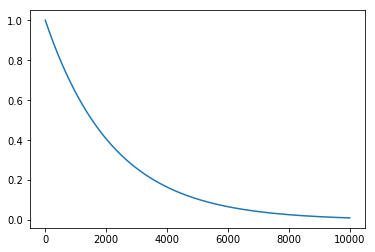

In [13]:

plt.plot(time, epsilon)
plt.show()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [14]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.7
        self.learning_rate = 0.02
        self.alpha_decay = 0.99
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = -0.00045
        self.epsilon_min = 0.001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate, decay=self.alpha_decay))
        print(model.summary())
        return model


    def get_action(self, state, possible_actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
             return random.choice(possible_actions)
        else:
            q_value = {}
            for action in possible_actions:
                enc_sa = env.state_encod_arch2(state,action).reshape(1,46)
                q_value[str(action)] = self.model.predict(enc_sa)
            keymax = max(q_value, key= lambda x:q_value.get(x))
            return eval(keymax)        
    

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, is_terminal = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state,action)   
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch2(next_state,action)
                is_terminal.append(is_terminal)
                
                # Write your code from here
                # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output) 
                #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                if is_terminal[i]:
                    target[i] = rewards[i]
                else: # non-terminal state
                    target[i] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
        # 4. Fit your model and track the loss values
            hist = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            return hist.history['loss']

    def save(self, name):
        self.model.save_weights(name)

In [15]:
Episodes = 10000
rewards_per_episode = []
loss_per_episode = []
agent = DQNAgent(46,1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1504      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,593
Trainable params: 2,593
Non-trainable params: 0
_________________________________________________________________
None


### DQN block

In [16]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    env = CabDriver()
    action_space, state_space, state = env.reset()
    rewards = 0
    loss = 0
    q_tracked = []
    #Call the DQN agent
    
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        possible_actions_index,actions = env.requests(state)
        action = agent.get_action(state, actions)
        next_state, is_terminal = env.next_state_func(state,action,Time_matrix)
        reward = env.reward_func(state,action,Time_matrix)
        agent.append_sample(state,action,reward,next_state)
        curr_loss = agent.train_model()
        loss+= curr_loss[0] if(curr_loss is not None) else 0
        rewards += reward
        terminal_state = is_terminal
        state = next_state
        
    rewards_per_episode.append(rewards)
    loss_per_episode.append(loss)
    # epsilon decay
    if (agent.epsilon > agent.epsilon_min):
        agent.epsilon = agent.epsilon_max*np.exp(agent.epsilon_decay*(episode))
    if episode % 100 == 0:
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode, rewards,len(agent.memory), agent.epsilon))
        # store q-values of some prespecified state-action pairs
        for stact in tracked_states.keys():
            lst = eval(stact)
            q_val = agent.model.predict(env.state_encod_arch2(lst[0:3],lst[3:]).reshape(1,46))
            tracked_states[stact].append(q_val[0][0])
save_obj(tracked_states, 'states_tracked')
save_obj(rewards_per_episode, 'rewards')
save_obj(loss_per_episode, 'loss')
# save model weights
agent.save('model_weights.h5') # save_model_weights(name="model_weights.h5")
        

episode 0, reward 90, memory_length 142, epsilon 1.0
episode 100, reward 1, memory_length 2000, epsilon 0.9559974818331
episode 200, reward -140, memory_length 2000, epsilon 0.9139311852712282
episode 300, reward -302, memory_length 2000, epsilon 0.8737159116880344
episode 400, reward -68, memory_length 2000, epsilon 0.835270211411272
episode 500, reward -270, memory_length 2000, epsilon 0.7985162187593771
episode 600, reward 66, memory_length 2000, epsilon 0.7633794943368531
episode 700, reward -261, memory_length 2000, epsilon 0.7297888742690568
episode 800, reward -135, memory_length 2000, epsilon 0.697676326071031
episode 900, reward 209, memory_length 2000, epsilon 0.6669768108584744
episode 1000, reward -67, memory_length 2000, epsilon 0.6376281516217733
episode 1100, reward 195, memory_length 2000, epsilon 0.6095709072963093
episode 1200, reward 104, memory_length 2000, epsilon 0.5827482523739896
episode 1300, reward 13, memory_length 2000, epsilon 0.5571058618121739
episode 140

### Tracking Convergence

In [17]:
tracked_states

{'[1,1,1,4,3]': [3.7290657,
  1.3756083,
  1.3079306,
  1.3141104,
  1.2985493,
  1.2478938,
  1.2483859,
  1.2545699,
  1.2683474,
  1.2644695,
  1.2625792,
  1.2667787,
  1.2694045,
  1.2723477,
  1.2710907,
  1.2670494,
  1.2675015,
  1.2661643,
  1.279563,
  1.2834996,
  1.2799464,
  1.2799196,
  1.2785205,
  1.2833633,
  1.2839241,
  1.2928121,
  1.2931396,
  1.298091,
  1.3041239,
  1.3067205,
  1.306308,
  1.3073862,
  1.3123091,
  1.3111216,
  1.314303,
  1.3164046,
  1.3206954,
  1.323199,
  1.3236609,
  1.3271704,
  1.326947,
  1.3262241,
  1.3260041,
  1.3266761,
  1.3315715,
  1.3363559,
  1.3399377,
  1.3445286,
  1.3473055,
  1.3510637,
  1.3542675,
  1.3566618,
  1.3605573,
  1.3645034,
  1.3696706,
  1.371213,
  1.3755304,
  1.3778481,
  1.3821064,
  1.3854165,
  1.3916364,
  1.3966862,
  1.399579,
  1.4020017,
  1.4052616,
  1.4106011,
  1.4128443,
  1.4149652,
  1.4168667,
  1.4181279,
  1.4207401,
  1.4215015,
  1.4246734,
  1.4241065,
  1.4277165,
  1.4299307,
  1.4

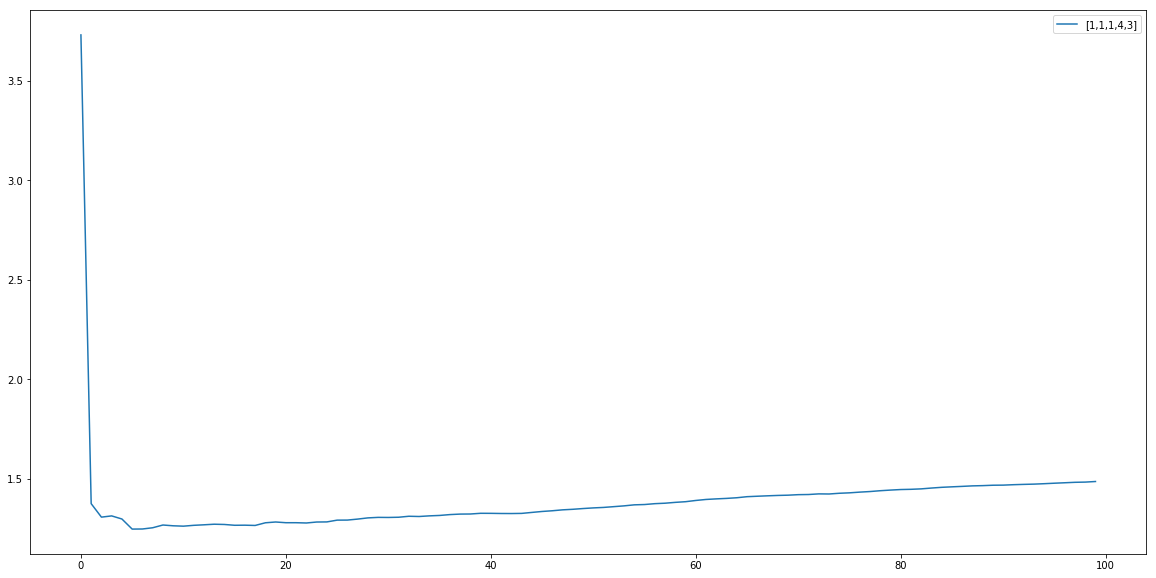

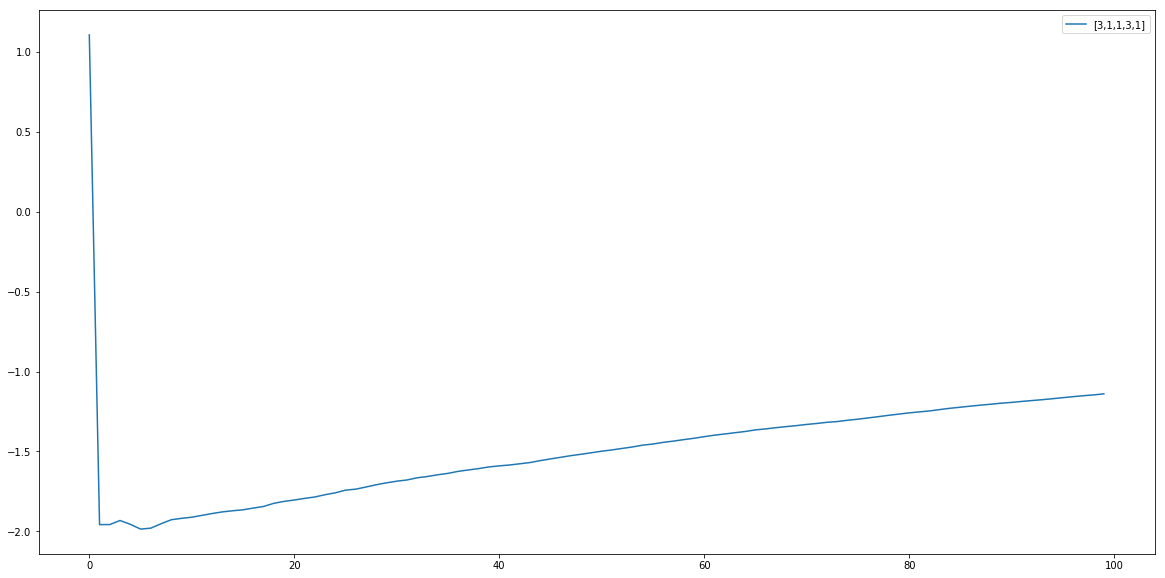

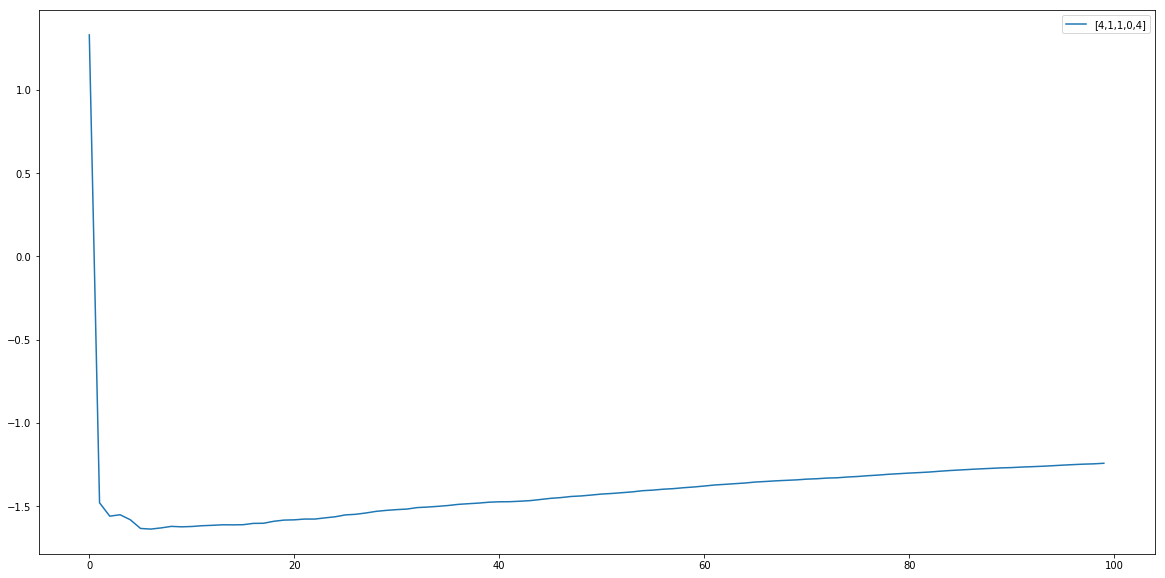

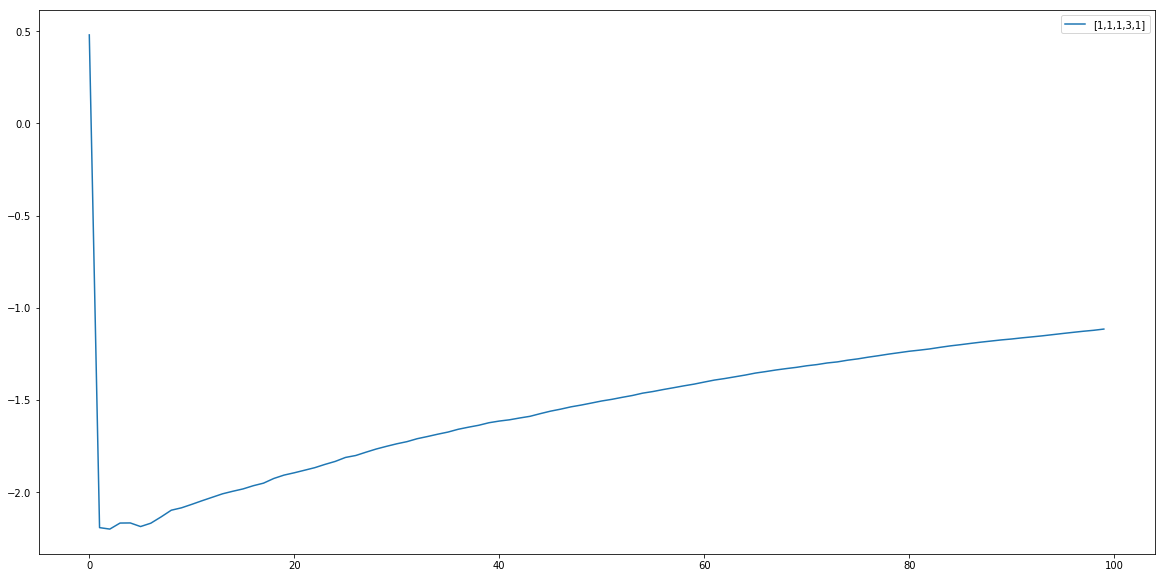

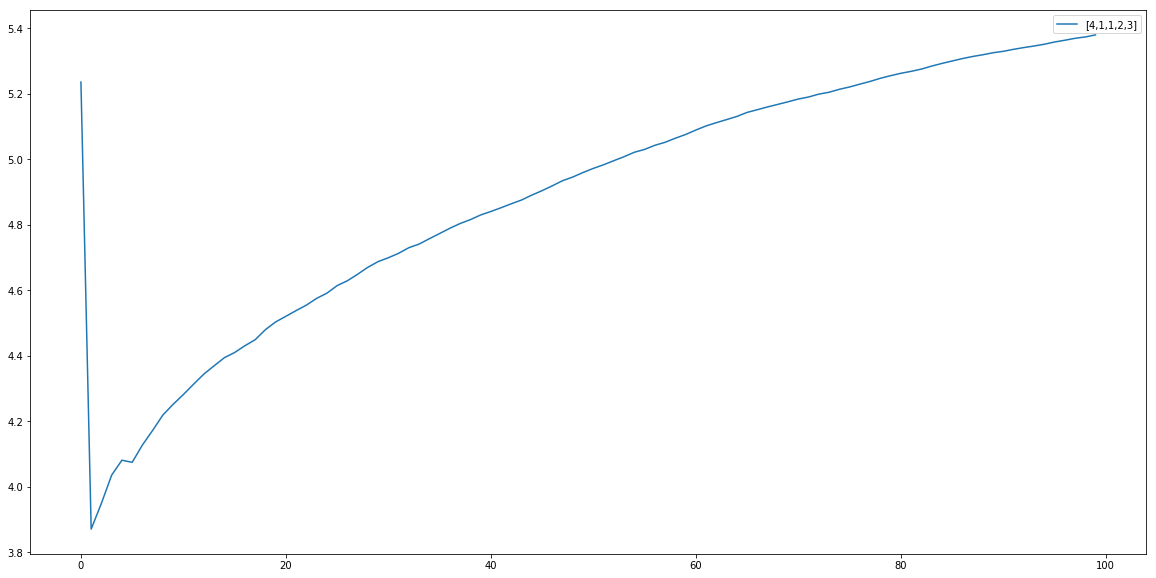

In [18]:
for state in tracked_states.keys():
    plt.figure(figsize=(20,10))
    plt.plot(tracked_states.get(state), label=state)
    plt.legend()
    plt.show()

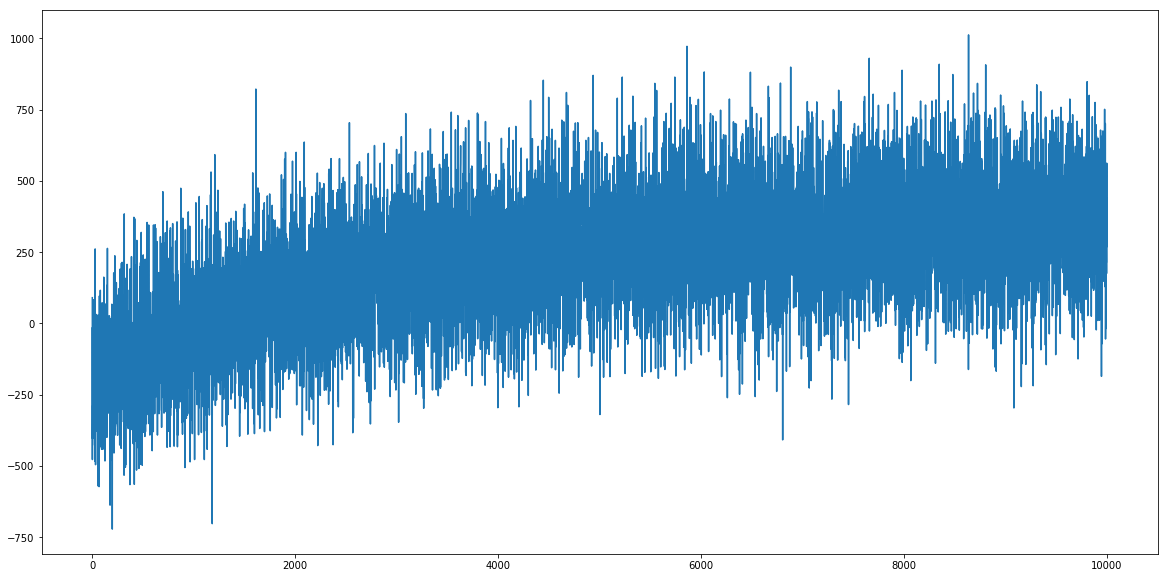

In [19]:
plt.figure(figsize=(20,10))
axes = plt.gca()
#axes.set_xlim([0,10000])
#axes.set_ylim([-100,2200])
plt.plot(rewards_per_episode)
plt.show()

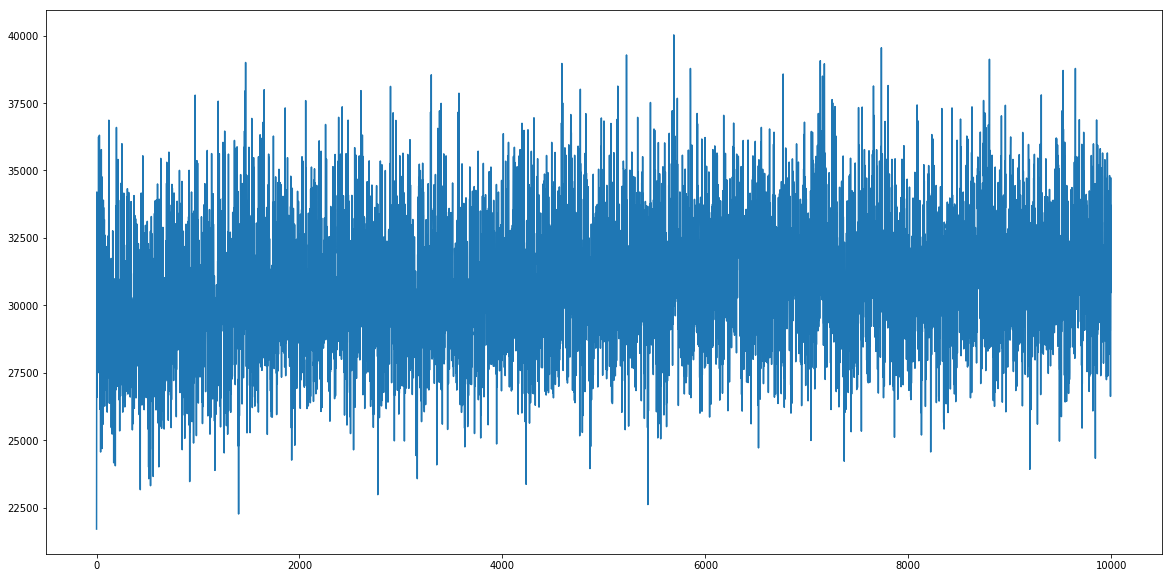

In [20]:
plt.figure(figsize=(20,10))
plt.plot(loss_per_episode)
plt.show()

In [21]:
#Maximum value of reward received
max(rewards_per_episode)

1012